In [1]:
%matplotlib ipympl

from matplotlib import pyplot as plt
import numpy as np
from matplotlib import animation
import ipywidgets as widgets

import optitrack.csv_reader as csv
from optitrack.geometry import *

filename = "../material/60fps/skeleton.csv"
# filename = "../material/60fps/rigidbody.csv"

### READ CSV AND LOAD DATA

In [2]:
# Read the file.
take = csv.Take().readCSV(filename)

# Print out some statistics
print("Found rigid bodies:", take.rigid_bodies.keys())

# Process the first rigid body into a set of planes.
bodies = take.rigid_bodies
skeletons = take.skeletons

bones_pos = []
rigid_body_markers_pos = []
markers_pos = []

if len(bodies) > 0:
    for body in bodies: 
        bones = take.rigid_bodies[body]
        n_frames = bones.num_total_frames()
        
        bones_pos.append(bones.positions)
        for marker in bones.rigid_body_markers.values():
            rigid_body_markers_pos.append(marker.positions)
            
        for marker in bones.rigid_body_markers.values():
            markers_pos.append(marker.positions)

if len(skeletons) > 0:
    for body in skeletons: 
        skeleton = take.skeletons[body]
        n_frames = skeleton.bones["Luca:Hip"].num_total_frames()
        
        for marker in skeleton.bones.values():
            rigid_body_markers_pos.append(marker.positions)
            
        for marker in skeleton.bone_markers.values():
            markers_pos.append(marker.positions)
        

#points = bones_pos + rigid_body_markers_pos + markers_pos
points = rigid_body_markers_pos + markers_pos

#points = [[0.0,0.0,0.0] if elem is None else elem for elem in markers for markers in points ]
points = [[[0.0, 0.0, 0.0] if frame is None else frame for frame in markers] for markers in points]

np_points = np.array(points)


Found rigid bodies: dict_keys([])


In [3]:
x = np_points[:,:,0]
y = np_points[:,:,1]
z = np_points[:,:,2]

### DISPLACE ANIMATION

In [4]:

# # Plot properties
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel('Z')

# ax.set_xlim(np.min(x), np.max(x))
# ax.set_ylim(np.min(y), np.max(y))
# ax.set_zlim(np.min(z), np.max(z))


# txt = fig.suptitle('')

# # initialize empty set of points
# points, = ax.plot([], [], [], "o")

# # define an animation function
# # this determines the plot's behavior at each frame
# def update(t):
#     txt.set_text('frame={:d}'.format(t))
#     # print(len(x[:,t]))
#     # update properties
#     updated_positions = np.array((x[:,t],y[:,t],z[:,t]), dtype=float)
    
#     points.set_data_3d(updated_positions)

#     # return modified artists
#     return points, txt

# ani=animtion.FuncAnimation(fig, update, frames=3000) 
# ani.save(filename="animations/animation.gif", writer="pillow", fps=60)

# #plt.show()

### DISPLACE ANIMATION

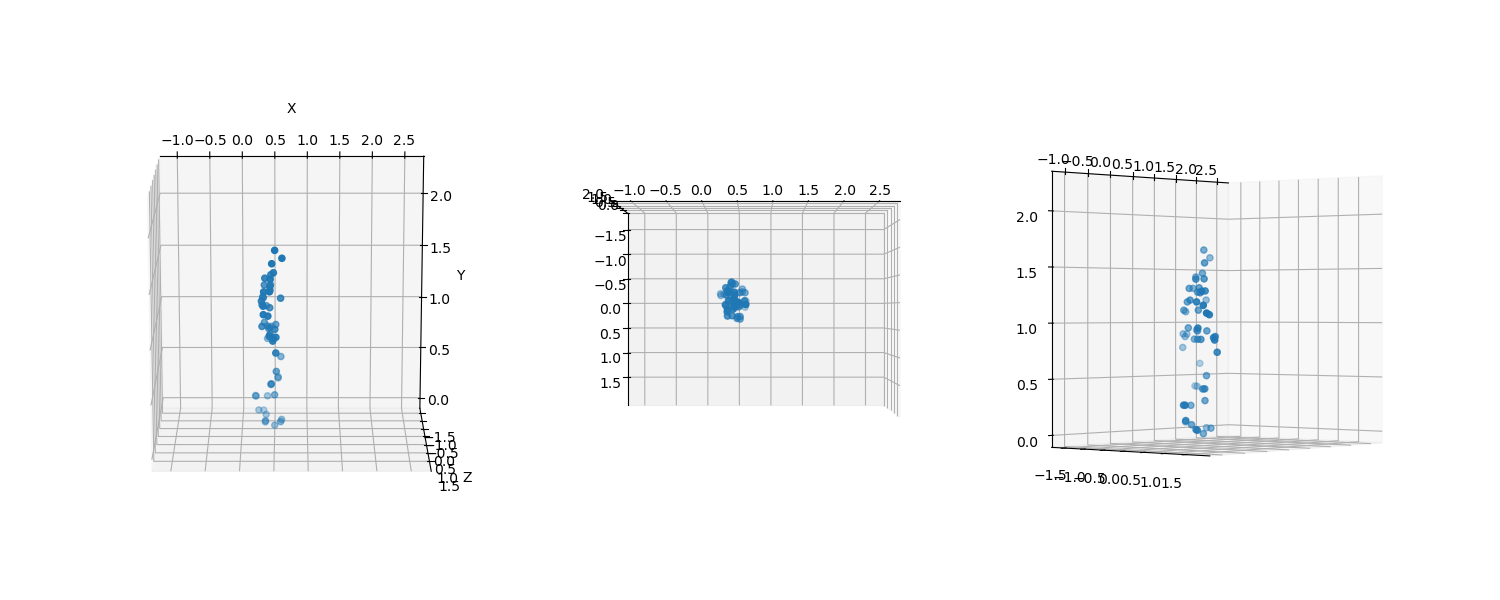

In [5]:
# Create a figure and axes for the plots
fig = plt.figure(figsize=(15, 6))  # Adjust the figure size as needed

# First subplot
ax1 = fig.add_subplot(131, projection='3d')
ax1.view_init(elev=105, azim=-90)  
points1, = ax1.plot([], [], [], "o")

# Second subplot
ax2 = fig.add_subplot(132, projection='3d')
ax2.view_init(elev=-180, azim=-90)  
points2, = ax2.plot([], [], [], "o")

# Third subplot
ax3 = fig.add_subplot(133, projection='3d')
ax3.view_init(elev=140, azim=0, roll=90)  
points3, = ax3.plot([], [], [], "o")

# Adjust margins and spacing between subplots
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.9, wspace=0.1, hspace=0.1)

# Define update function
def update(t):
    ax1.clear()
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    ax1.set_xlim(np.min(x), np.max(x))
    ax1.set_ylim(np.min(y), np.max(y))
    ax1.set_zlim(np.min(z), np.max(z))
    ax1.scatter(x[:, t], y[:, t], z[:, t])

    ax2.clear()
    ax2.set_xlim(np.min(x), np.max(x))
    ax2.set_ylim(np.min(y), np.max(y))
    ax2.set_zlim(np.min(z), np.max(z))
    ax2.scatter(x[:, t], y[:, t], z[:, t])

    ax3.clear()
    ax3.set_xlim(np.min(x), np.max(x))
    ax3.set_ylim(np.min(y), np.max(y))
    ax3.set_zlim(np.min(z), np.max(z))
    ax3.scatter(x[:, t], y[:, t], z[:, t])

# Create slider widget
frame_slider = widgets.IntSlider(value=0, min=0, max=n_frames-1, step=1, description='Frame:')

# Define function to update plot when slider changes
def slider_changed(change):
    update(change.new)

# Link slider and update function
frame_slider.observe(slider_changed, 'value')

# Create play button
play_button = widgets.Play(
    value=0,
    min=0,
    max=n_frames-1,
    step=1,
    description="Play",
    interval=1  # Adjust the interval (in milliseconds) as needed
)

# Link play button and slider
widgets.jslink((play_button, 'value'), (frame_slider, 'value'))

# Display play button and slider
display(widgets.HBox([play_button, frame_slider]))

# Initial plot
update(0)

### SAVE THE ANIMATION 

In [6]:
# Create animation
# anim = animation.FuncAnimation(fig, update, frames=n_frames, interval=100)

# Save animation as GIF
# anim.save('animations/animation.gif', writer='pillow', fps=60)